Script to load extracted windowed feature set, data preparation for model training and prediction of Parkinson's symptom severity

## Mount Notebook to Google Drive

In [22]:
from google.colab import drive
drive.mount('/content/drive')

#Change this directory to the location of the shared 1004.csv file after mounting your Drive to the Colab
savedir = "/content/drive/My Drive/CA683_Assignment-2/Data/Extracted_Features/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Prior to running this script, please add a shortcut of the shared data folder containing the sample measurement files provided and extracted feature set to your Google Drive (right click on the folder in question, and then click "Add shortcut to Drive")

# Load libraries

In [0]:
RANDOM_SEED = 42
import numpy as np
import pandas as pd
import re
import dill
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy import interp
from os import listdir
from os.path import isfile, join
from collections import defaultdict 
from imblearn.combine import SMOTETomek
from numpy import mean
from mlxtend.plotting import plot_decision_regions
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, LeaveOneOut, ShuffleSplit, cross_val_predict, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.datasets import make_classification, fetch_openml
from sklearn.preprocessing import label_binarize, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, average_precision_score, precision_recall_curve
from itertools import cycle
from sklearn import svm, datasets
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

random_state = np.random.RandomState(0)
labelencoder= LabelEncoder()

# Functions

## Data Prep

### Count label Frequency

In [0]:
#Count the frequency of classes in the target variable
def CountFrequency(my_list): 
  # Creating an empty dictionary  
  freq = {} 
  for item in my_list: 
      if (item in freq): 
          freq[item] += 1
      else: 
          freq[item] = 1
  label_count = {}
  for key, value in freq.items(): 
    label_count[key] = value
    print ("% d : % d"%(key, value)) 
  return label_count

### Prepare X data

In [0]:
#Prepares X feature data preprocessing
def prep_var(X):
  X['Activity_Label'] = labelencoder.fit_transform(X['Activity_Label']) #fitting and transforming the desired categorical column.
  #Include only numeric cols
  X = X.select_dtypes(include=numerics)
  #Exclude objects
  X = X.select_dtypes(exclude=objs)
  #Normalize feats
  X = normalize(X)
  #Cov to DF
  X = pd.DataFrame(X)
  #NA to num 
  X[:] = np.nan_to_num(X)
  #Convert to DF
  X = pd.DataFrame(X)
  return X

### Prepare X DF pre mod

In [0]:
#Drop any unwanted columns from feature sets
def X_split_setup(df, columns_lab, target):
  X = df[df.columns.drop(list(columns_lab))]
  X = X[X.columns.drop((target))]
  return X

### Normalize DF

In [0]:
#Normalize the X column data using column max and min
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

### PCA X

In [0]:
def PCA_Xonly(X, n_PCA=35):
  pca = PCA(n_components=n_PCA)
  try:
    X = pca.fit_transform(X)
  except:
    pca = PCA(n_components=int(round(X.shape[1] * 0.7)))
    X = pca.fit_transform(X)
  print('Total Explained variance: ' + str(sum(pca.explained_variance_ratio_)))

  X = pd.DataFrame(X)
  return X

In [0]:
#Run PCA on feature set
def PCA_X(X_train, X_test, n_PCA=35):
  pca = PCA(n_components=n_PCA)
  try:
    X_train = pca.fit_transform(X_train)
  except:
    pca = PCA(n_components=int(round(X_train.shape[1] * 0.7)))
    X_train = pca.fit_transform(X_train)
  X_test = pca.transform(X_test)
  print('Total Explained variance: ' + str(sum(pca.explained_variance_ratio_)))

  X_train = pd.DataFrame(X_train)
  X_test = pd.DataFrame(X_test)
  return X_train, X_test

###Meas Split

In [0]:
# Loop to iterate through measurements, count its target class and split into train and test depending on the ratio
#Returns list of train and test measurement ids to be used for splitting
def get_meas_list(dfcur, unique_meas, split_ratio = 0.8):
  curr_label_count = {}
  train_meas = []
  test_meas = []
  for meas in unique_meas:
    curr_label = dfcur.loc[dfcur['measurement_id']==str(meas)][target].values[0]
    curr_label_count[str(curr_label)] = curr_label_count.get(str(curr_label), 0) + 1
    if curr_label_count[str(curr_label)] <= int(round(label_count[curr_label] * split_ratio)):
      train_meas.append(meas)
    else:
      test_meas.append(meas)
  return train_meas, test_meas

### Reset df index

In [0]:
# Resets the row index of a dataframe
def reset_idx(df):
  df = df.reset_index()
  df = df[df.columns.drop(('index'))]
  return df

### VIF

In [0]:
#Iterative VIF function to drop out any features with VIF > 10
#Returns updated Feature set and list of feature indices
#https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-in-python
def calculate_vif(X, thresh=10.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables], variables

### Resampling - SMOTETOMEK

In [0]:
#Resamples X, y dataframes using TOMEK resampling method
def smotetomek(X, y, sampling_strategy='not majority'):
  smt = SMOTETomek(ratio='auto', sampling_strategy=sampling_strategy)
  X_res, y_res = smt.fit_sample(X, y.values.ravel())
  return X_res, y_res

## Evaluation

### Rep K-Fold CV

In [0]:
# K fold cross validation on with multiple classifiers optimizing for ROC AUC OVR scores
# Returns ROC scores
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
def repKFoldVal(X, y):
  X_s, y_s = shuffle(X, y)

  seed = 7
  scoring = 'roc_auc_ovr'
  # Spot Check Algorithms
  models = []
  models.append(('LR', LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter = 1000)))
  models.append(('LDA', LinearDiscriminantAnalysis()))
  models.append(('EasyEnsemble', EasyEnsembleClassifier(n_estimators=50,n_jobs=-1)))
  models.append(('BalancedBagging', BalancedBaggingClassifier(n_estimators=50,  n_jobs=-1)))
  models.append(('RandF', RandomForestClassifier(n_estimators=50, class_weight="balanced", n_jobs=-1)))
  models.append(('CART', DecisionTreeClassifier(class_weight="balanced")))
  models.append(('NB', GaussianNB()))
  # evaluate each model in turn
  results = []
  names = []
  print('K-fold cross validation ROC scores : Mean (STD)')
  for name, model in models:
    kfold = KFold(n_splits= 3)
    cv_results = cross_val_score(model, X_s, y_s.values.ravel(), cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

### Extra Trees Classifier - Feature Importance

In [0]:
# Extra trees classifier to show greatest feature importance
# Returns index of feature importance
def extra_trees(X, y):
  # Build a forest and compute the feature importances
  forest = ExtraTreesClassifier(n_estimators=30,
                                random_state=0, class_weight='balanced')
  forest.fit(X_train, y_train)
  importances = forest.feature_importances_
  std = np.std([tree.feature_importances_ for tree in forest.estimators_],
              axis=0)
  indices = np.argsort(importances)[::-1]
  # Print the feature ranking
  print("Feature ranking:")
  for f in range(X_train.shape[1]):
      print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

  # Plot the feature importances of the forest
  plt.xticks(range(X_train.shape[1]), indices)
  plt.xlim([-1, X_train.shape[1]])
  mybel =-1
  count =0
  for f in range(X_train.shape[1]): 
    plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center", label=[f+1, X_train.columns[indices[f]]])                    
    plt.legend()
    plt.title("Feature importances")
  plt.show()
  return indices

### ROC AUCs plotter

In [0]:
# ROC AUC plotting function for multiclass problem
def auc_plotter(y_test_bi, classes_pred, y_pred_bi):
  #https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#multiclass-settings

  try:
    #AUC ROC OVR and OVO
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(classes_pred)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bi[:, i], y_pred_bi[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bi.ravel(), y_pred_bi.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    lw = 2

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multicalss Receiver Operating Characteristic - ROC AUC')
    plt.legend(loc="lower right")
    plt.show()  

    #AUPR
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bi[:, i],
                                                            y_pred_bi[:, i])
        average_precision[i] = average_precision_score(y_test_bi[:, i], y_pred_bi[:, i])

    # A "macro-average": quantifying score on all classes jointly
    precision["macro"], recall["macro"], _ = precision_recall_curve(y_test_bi.ravel(),
        y_pred_bi.ravel())
    average_precision["macro"] = average_precision_score(y_test_bi, y_pred_bi,
                                                        average="macro")
    print('Average precision score, macro-averaged over all classes: {0:0.2f}'
          .format(average_precision["macro"]))

    plt.figure()
    plt.step(recall['macro'], precision['macro'], where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
        'Average precision score, macro-averaged over all classes: AP={0:0.2f}'
        .format(average_precision["macro"]))
    plt.show() 
  except:
    print('\n Failed to plot AUC')

### Hyperparameter tuning

## Models

### Random Forest Classifier

In [0]:
#Random Forest Classifier
#Returns trained model and report
def randF_simple(X_train, X_test, y_train, y_test, tuned):
  
  #setup dfs
  classes_tr = y_train.iloc[0:, 0].unique()
  classes_test = y_test.iloc[0:, 0].unique()
  y_train_bi = label_binarize(y_train, classes = classes_tr)
  y_test_bi = label_binarize(y_test, classes = classes_test)

  #Train the model
  if tuned == False:
    clf = RandomForestClassifier()
  else:
    clf = RandomForestClassifier(n_estimators=200, class_weight="balanced", max_features='auto', min_samples_leaf=10, criterion='gini')
  clf.fit(X_train, y_train.values.ravel())
  #All Train predictions
  #train_preds = clf.predict(X)
  #Split set test preds
  y_pred = clf.predict(X_test)
  classes_pred = y_test.iloc[0:, 0].unique()
  y_pred_bi = label_binarize(y_pred, classes = classes_pred)
  #Accuracy scores
  Acc_train = clf.score(X_train, y_train)
  Acc_test = clf.score(X_test, y_test)

  #AUC evaluation
  macro_roc_auc_ovr = roc_auc_score(y_test_bi, y_pred_bi, multi_class="ovr",
                                    average="macro")
  weighted_roc_auc_ovr = roc_auc_score(y_test_bi, y_pred_bi, multi_class="ovr",
                                      average="weighted")
  macro_roc_auc_pr = average_precision_score(y_test_bi, y_pred_bi, average="macro")
  weighted_roc_auc_pr = average_precision_score(y_test_bi, y_pred_bi, average="weighted")
  
  print('Training Accuracy score: ', round(Acc_train, 3))
  print('\nTest set results')
  print('Test Accuracy score: ',round(Acc_test, 3))
  print('Macro ROC AUC score per class :', round(macro_roc_auc_ovr, 3) )
  print('Weighted ROC AUC score :', round(weighted_roc_auc_ovr, 3))
  print('Macro ROC AUPrecision curve value per class :', round(macro_roc_auc_pr, 3))
  print('Weighted ROC AUPrecision curve value :', round(weighted_roc_auc_pr, 3))
  #Classification report
  report = classification_report(y_test, y_pred)
  print("\n classification report: \n", report)

  #Unlabelled test data predictions
  #y_pred_dataset = clf.predict(test_set)
  #df = pd.DataFrame(columns=['measurement_id', 'prediction'])
  #df['measurement_id'] = test_measures
  #df['prediction'] = y_pred_dataset
  #df = df.groupby(['measurement_id']).agg(pd.Series.mode)

  report = pd.DataFrame({'User': [''], 
              'Subchallenge': [''],
        'Model': [''], 
        'Accuracy_train': [Acc_train],
        'Accuracy_test': [Acc_test],
        'ROC_AUC_Macro': [macro_roc_auc_ovr],
        'ROC_AUC_Weighted': [weighted_roc_auc_ovr],
        'ROC_AUPR_Macro': [macro_roc_auc_pr],
        'ROC_AUPR_Weighted': [weighted_roc_auc_pr]})
  
  #train_preds_df = pd.DataFrame(columns=['measurement_id', 'prediction','actual'])
  #train_preds_df['measurement_id'] = train_measures
  #train_preds_df['prediction'] = train_preds
  #train_preds_df['actual'] = y.values
  #train_preds_df = train_preds_df.groupby(['measurement_id']).agg(pd.Series.mode)

  #plot auc results
  auc_plotter(y_test_bi, classes_pred, y_pred_bi)

  return clf, report

# Load user data

In [177]:
user = 1004 #User number
df = pd.read_csv(savedir + str(user) + '.csv')

#Columns to be removed
df = df[df.columns.drop(list(df.filter(regex='Unn')))]
columns_lab = ['Timestamp', 'Reading',
            'subject_id']
df.columns

Index(['on_off', 'tremor', 'dyskinesia', 'Timestamp', 'Reading',
       'measurement_id', 'subject_id', 'X', 'Y', 'Z',
       ...
       'Y_bp_filt_[3.5, 7.5]_signal_entropy',
       'Z_bp_filt_[3.5, 7.5]_signal_entropy',
       'X_bp_filt_[0.25, 3.5]_signal_entropy',
       'Y_bp_filt_[0.25, 3.5]_signal_entropy',
       'Z_bp_filt_[0.25, 3.5]_signal_entropy', 'PC1_[3.5, 7.5]_signal_entropy',
       'PC1_[0.25, 3.5]_signal_entropy', 'hand_movement', 'hand_amp',
       'hand_jerk'],
      dtype='object', length=274)

In [178]:
#Select Numeric features in df
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df.select_dtypes(include=numerics)
#Select Object features in df
objs = ['O']
df.select_dtypes(include=objs)

,measurement_id,Activity_Label
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,Inactivity
1,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,Inactivity
2,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,Inactivity
3,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,Inactivity
4,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,Inactivity
...,...,...
101136,11dfbcf2-cd03-4b10-83b4-ad428153b200,Inactivity
101137,11dfbcf2-cd03-4b10-83b4-ad428153b200,Inactivity
101138,11dfbcf2-cd03-4b10-83b4-ad428153b200,Inactivity
101139,11dfbcf2-cd03-4b10-83b4-ad428153b200,Inactivity


In [0]:
#Split df into seperate dfs for each target variable
df_on_off = df.drop(labels= ['tremor', 'dyskinesia'], axis=1)
df_trem = df.drop(labels= ['on_off', 'dyskinesia'], axis=1)
df_dys = df.drop(labels= ['on_off', 'tremor'], axis=1)
df_on_off = df_on_off[df_on_off['on_off'].notna()]
df_trem = df_trem[df_trem['tremor'].notna()]
df_dys = df_dys[df_dys['dyskinesia'].notna()]
df_on_off = df_on_off.fillna(df_on_off.median())
df_trem = df_trem.fillna(df_trem.median())
df_dys = df_dys.fillna(df_dys.median())

#Modelling

##Tremor

In [0]:
target = 'tremor'

dfcur = df_trem # Set the DF to tremor
y = dfcur[target] # Set the y to tremor
measurement_id = dfcur['measurement_id']

#Removed unwanted columns from feature set
X = X_split_setup(dfcur, columns_lab, target)

#Prep the target variable df
y_train, y_test = pd.DataFrame(columns=[target]),pd.DataFrame(columns=[target])

### Split measurements proportionately by class

In [211]:
#Drop unwanted columns
dfcur = dfcur[dfcur.columns.drop(list(dfcur.filter(regex='Rows')))]

#Get a list of unique measurement ids for splitting - can't split measurements across train:test
unique_meas = set(measurement_id)
unique_df = pd.DataFrame(dfcur.groupby(['measurement_id']).median())

#Count class in target
label_count = CountFrequency(unique_df[target]) 

#Split measurement ids
train_meas, test_meas = get_meas_list(dfcur, unique_meas, split_ratio = 0.8)

#Check if any meausurement ids are shared in the split - expect False
train_df = dfcur[dfcur['measurement_id'].isin(train_meas)]
test_df = dfcur[dfcur['measurement_id'].isin(test_meas)]
print('\nAre any train/test measurement_ids shared? \n' + str(bool(set(train_df['measurement_id'])&set(test_df['measurement_id']))))

 0 :  41
 1 :  16
 2 :  10
 3 :  14
 4 :  1

Are any train/test measurement_ids shared? 
False


###Data prep

In [0]:
#X prep
X_train = X_split_setup(train_df, columns_lab, target)
X_test = X_split_setup(test_df, columns_lab, target)

#Prep the data - impute nas and encode any categorical features
X_train = prep_var(X_train)
X_test = prep_var(X_test)

#y prep
y_train[target] = train_df[target]
y_test[target] = test_df[target]

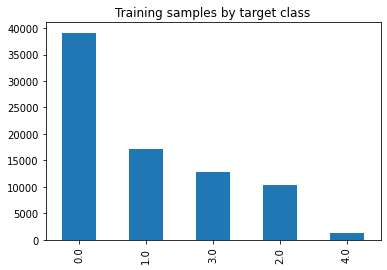

In [185]:
y_train[target].value_counts().plot(kind='bar', title='Training samples by target class');

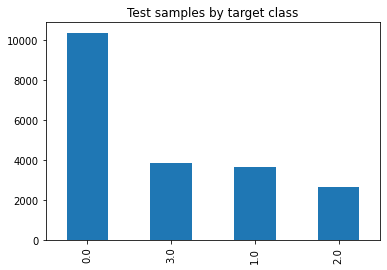

In [186]:
y_test[target].value_counts().plot(kind='bar', title='Test samples by target class');

### Dimensionality reduction

#### VIF - slow - not used

In [0]:
#VIF - will take hours !!!!!!!!!!!
X_train_vif, X_train_vif_feats = calculate_vif(X_train)
#Uses selected VIF features to reduce X test feature set
X_test_vif = X_test[X_train_vif_feats]
#Print out feature indices
X_train_vif_feats

#### Extra Trees - Feature importance - Not used

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Feature ranking:
1. feature 0 (0.016495)
2. feature 7 (0.015106)
3. feature 2 (0.014465)
4. feature 6 (0.014181)
5. feature 25 (0.013821)
6. feature 24 (0.013702)
7. feature 18 (0.013498)
8. feature 8 (0.013339)
9. feature 1 (0.013106)
10. feature 20 (0.013065)
11. feature 19 (0.012560)
12. feature 264 (0.012391)
13. feature 152 (0.012077)
14. feature 26 (0.011478)
15. feature 208 (0.008009)
16. feature 33 (0.007396)
17. feature 214 (0.007297)
18. feature 225 (0.007105)
19. feature 202 (0.006899)
20. feature 210 (0.006622)
21. feature 209 (0.006573)
22. feature 161 (0.006550)
23. feature 4 (0.006516)
24. feature 203 (0.006474)
25. feature 265 (0.006356)
26. feature 132 (0.006202)
27. feature 159 (0.006046)
28. feature 250 (0.005985)
29. feature 222 (0.005980)
30. feature 120 (0.005739)
31. feature 247 (0.005677)
32. feature 200 (0.005662)
33. feature 206 (0.005660)
34. feature 164 (0.005587)
35. feature 116 (0.005429)
36. feature 205 (0.005300)
37. feature 223 (0.005284)
38. feature 21

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


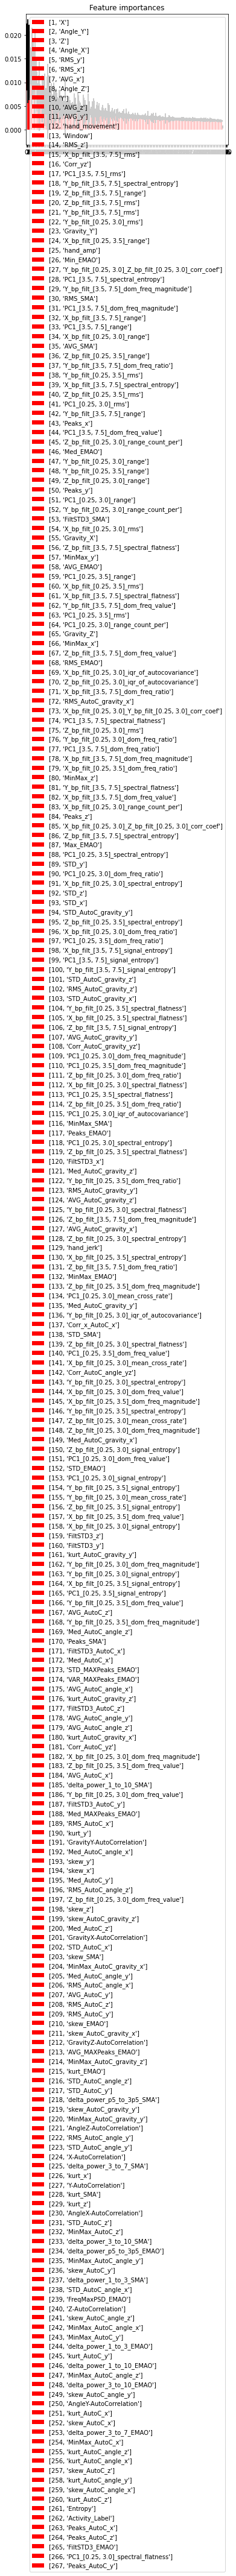

Indices of descedning feature importance


array([  0,   7,   2,   6,  25,  24,  18,   8,   1,  20,  19, 264, 152,
        26, 208,  33, 214, 225, 202, 210, 209, 161,   4, 203, 265, 132,
       159, 250, 222, 120, 247, 200, 206, 164, 116, 205, 223, 212, 220,
       213, 163, 201,  34, 246, 198, 134, 165, 204, 166,  35, 167, 197,
       124, 160,   3, 229,  28, 118, 207, 211, 219, 221, 215, 199,   5,
        27, 226, 121, 168, 170, 218,  73, 157, 249, 162, 179, 248, 217,
       233,  29, 224, 216, 196,  36, 158, 230, 133, 255,  22, 189, 176,
        23,  21,  65, 245, 174, 253, 256, 262, 257,  66,  75,  64, 239,
       234, 258,  56,  92, 188, 252, 184, 175, 254, 243, 171, 122, 127,
       191, 244,  30,  48, 238,  74,  57, 180, 227,  55, 186, 266, 235,
       228, 123, 242, 195,  47, 169,  94, 117, 185, 251, 192,  93, 181,
       172, 232, 240, 194, 183,  46, 155, 187, 119, 156, 260, 193, 261,
       231, 153,  32,  31, 111, 178, 154, 259, 263, 236,  54, 237,  51,
       126,  88,  43, 137, 138,  58, 112,  90,  59,  60, 110,  9

In [46]:
#Decision trees classifier - feature importance
extra_t_indices = extra_trees(X_train, y_train)
print('Indices of descedning feature importance')
extra_t_indices # Can use the index list to select top x features to reduce dimensionality

#### PCA - used

In [189]:
#PCA for dimensionality reduction - 35 principal components explain >80% of the variance
X = prep_var(X)
X_train= prep_var(X_train)
X_test = prep_var(X_test)

#PCA
X = PCA_Xonly(X)
X_train, X_test = PCA_X(X_train, X_test)

Total Explained variance: 0.8183194366064739
Total Explained variance: 0.8181059455338727


###Modelling

#### Model Selection

In [138]:
#Repeated K fold CV to choose optimal model based on ROC scores
#Full dataset
repKFoldVal(X, y)

K-fold cross validation ROC scores : Mean (STD)
LR: 0.689765 (0.001674)
LDA: 0.694493 (0.000253)
EasyEnsemble: 0.659116 (0.001455)
BalancedBagging: 0.770451 (0.000098)
RandF: 0.803596 (0.002854)
CART: 0.628790 (0.002083)
NB: 0.701948 (0.000782)


In [130]:
#Train
repKFoldVal(X_train, y_train)

K-fold cross validation ROC scores : Mean (STD)
LR: 0.701235 (0.003363)
LDA: 0.704931 (0.003356)
EasyEnsemble: 0.664133 (0.000722)
BalancedBagging: 0.778695 (0.002084)
RandF: 0.808469 (0.001315)
CART: 0.631000 (0.001353)
NB: 0.708925 (0.003383)


In [131]:
#Test
repKFoldVal(X_test, y_test)

K-fold cross validation ROC scores : Mean (STD)
LR: 0.752124 (0.000330)
LDA: 0.751207 (0.000939)
EasyEnsemble: 0.736780 (0.006928)
BalancedBagging: 0.884941 (0.000630)
RandF: 0.876788 (0.001899)
CART: 0.693096 (0.002634)
NB: 0.747736 (0.001891)


From Repeated K Fold cross validation, Overall Random Forest was the optimal model for mean and std ROC scores from the tested models

#### Hyperparameter tuning

In [147]:
# Tuning the random forest model prior to predicting test set
#https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv
from sklearn.model_selection import GridSearchCV# Number of trees in random forest
rfc = RandomForestClassifier(random_state = 42)
param_grid = { 'max_features':['auto', 'sqrt'],'n_estimators':[50],'criterion' :['gini', 'entropy'], 'min_samples_leaf': [10,100], 'class_weight': ['balanced']}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [149]:
CV_rfc.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'n_estimators': 50}

From tuning the hyperparameters these were optimal for modelling

###Evaluation

#### Random Forest - standard

Training Accuracy score:  1.0

Test set results
Test Accuracy score:  0.506
Macro ROC AUC score per class : 0.527
Weighted ROC AUC score : 0.531
Macro ROC AUPrecision curve value per class : 0.267
Weighted ROC AUPrecision curve value : 0.356

 classification report: 
               precision    recall  f1-score   support

         0.0       0.52      0.92      0.67     10350
         1.0       0.44      0.16      0.23      3657
         2.0       0.17      0.02      0.03      2665
         3.0       0.28      0.06      0.09      3841
         4.0       0.00      0.00      0.00         0

    accuracy                           0.51     20513
   macro avg       0.29      0.23      0.20     20513
weighted avg       0.42      0.51      0.40     20513



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


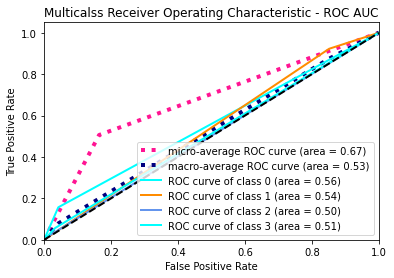

Average precision score, macro-averaged over all classes: 0.27


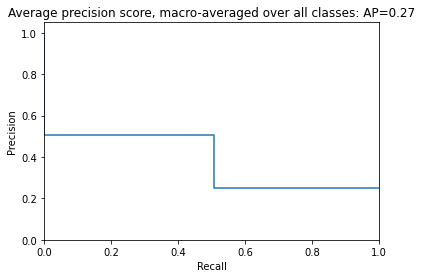

In [190]:
clf, report = randF_simple(X_train, X_test, y_train, y_test, tuned=False)

#### Random Forest- hyperparamter tuning

Training Accuracy score:  0.924

Test set results
Test Accuracy score:  0.415
Macro ROC AUC score per class : 0.554
Weighted ROC AUC score : 0.559
Macro ROC AUPrecision curve value per class : 0.276
Weighted ROC AUPrecision curve value : 0.369

 classification report: 
               precision    recall  f1-score   support

         0.0       0.57      0.58      0.57     10350
         1.0       0.28      0.22      0.25      3657
         2.0       0.18      0.16      0.17      2665
         3.0       0.29      0.33      0.31      3841
         4.0       0.00      0.00      0.00         0

    accuracy                           0.42     20513
   macro avg       0.26      0.26      0.26     20513
weighted avg       0.41      0.42      0.41     20513



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


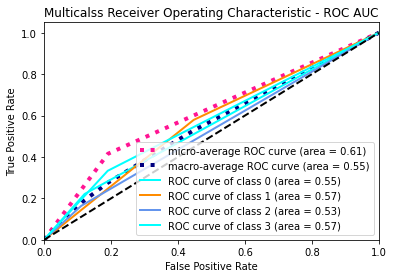

Average precision score, macro-averaged over all classes: 0.28


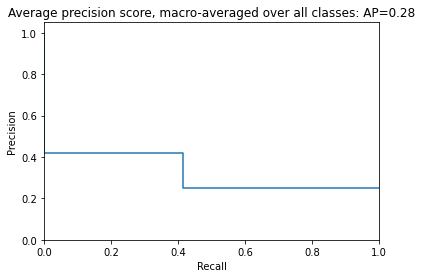

In [191]:
clf, report = randF_simple(X_train, X_test, y_train, y_test, tuned = True)

The tuning of the hyperparameters did not seem to improve the results so the default Random Classifier was chosen instead

#### Random Forest with Resampling - Smote Tomek

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Training Accuracy score:  1.0

Test set results
Test Accuracy score:  0.325
Macro ROC AUC score per class : 0.548
Weighted ROC AUC score : 0.546
Macro ROC AUPrecision curve value per class : 0.276
Weighted ROC AUPrecision curve value : 0.282

 classification report: 
               precision    recall  f1-score   support

         0.0       0.25      0.26      0.25      5254
         1.0       0.40      0.42      0.41      6298
         2.0       0.30      0.26      0.28      5055
         3.0       0.33      0.35      0.34      3841
         4.0       0.00      0.00      0.00         0

    accuracy                           0.32     20448
   macro avg       0.26      0.26      0.26     20448
weighted avg       0.33      0.32      0.32     20448



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


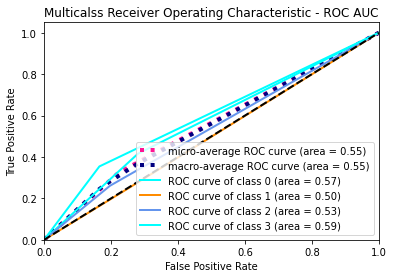

Average precision score, macro-averaged over all classes: 0.28


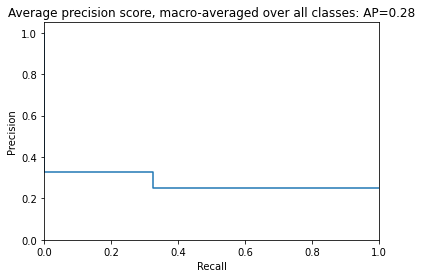

In [222]:
#Smote Tomek resampling to improve class imbalance
X_train_res, y_train_res = smotetomek(X_train, y_train)
y_train_res = pd.DataFrame(y_train_res)
clf, report = randF_simple(X_train_res, X_test, y_train_res, y_test, tuned = False)

Resampling did not seem to improve results

###Tremor focused features

####Human acitivty detection - reduce samples

In [212]:
#Remove non hand movement sections - improve accuracy as tremor severity is linked with hand movements
#X prep
y = dfcur[target]
y_train, y_test = pd.DataFrame(columns=[target]),pd.DataFrame(columns=[target])

X_train = X_split_setup(train_df, columns_lab, target)
X_test = X_split_setup(test_df, columns_lab, target)

#y prep
y_train[target] = train_df[target]
y_test[target] = test_df[target]

#reset indices for hand_movement removal
X_train = reset_idx(X_train)
X_test = reset_idx(X_test)
y_train = reset_idx(y_train)
y_test = reset_idx(y_test)

#indices for hand movement <1
train_hand = X_train.index[X_train['hand_movement']<1].tolist()
test_hand = X_test.index[X_test['hand_movement']<1].tolist() 

#remove hand movements off
X_train = X_train.drop(X_train.index[train_hand])
X_test = X_test.drop(X_test.index[test_hand])
y_train = y_train.drop(y_train.index[train_hand])
y_test = y_test.drop(y_test.index[test_hand])

X_train = prep_var(X_train)
X_test = prep_var(X_test)
X_train, X_test = PCA_X(X_train, X_test)

Total Explained variance: 0.7841841278344527


Training Accuracy score:  1.0

Test set results
Test Accuracy score:  0.563
Macro ROC AUC score per class : 0.519
Weighted ROC AUC score : 0.529
Macro ROC AUPrecision curve value per class : 0.258
Weighted ROC AUPrecision curve value : 0.432

 classification report: 
               precision    recall  f1-score   support

         0.0       0.63      0.90      0.74      7239
         1.0       0.10      0.02      0.04      1779
         2.0       0.26      0.04      0.07      1829
         3.0       0.16      0.13      0.14      1165

    accuracy                           0.56     12012
   macro avg       0.29      0.27      0.25     12012
weighted avg       0.45      0.56      0.47     12012



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


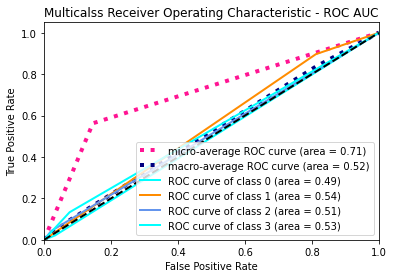

Average precision score, macro-averaged over all classes: 0.26


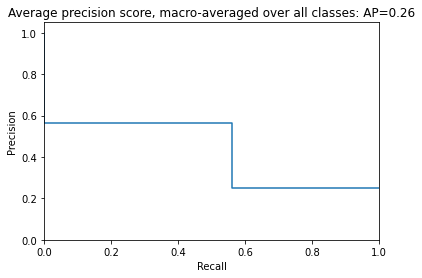

In [194]:
#Model
#X_train_res, y_train_res = smotetomek(X_train, y_train)
#y_train_res = pd.DataFrame(y_train_res)
clf, report = randF_simple(X_train, X_test, y_train, y_test, tuned = False)

#### Tremor frequency metrics

Total Explained variance: 0.9856701719887808
Training Accuracy score:  1.0

Test set results
Test Accuracy score:  0.455
Macro ROC AUC score per class : 0.499
Weighted ROC AUC score : 0.498
Macro ROC AUPrecision curve value per class : 0.25
Weighted ROC AUPrecision curve value : 0.338

 classification report: 
               precision    recall  f1-score   support

         0.0       0.50      0.85      0.63     10350
         1.0       0.15      0.05      0.08      3657
         2.0       0.21      0.02      0.04      2665
         3.0       0.18      0.06      0.09      3841
         4.0       0.00      0.00      0.00         0

    accuracy                           0.46     20513
   macro avg       0.21      0.20      0.17     20513
weighted avg       0.34      0.46      0.36     20513



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


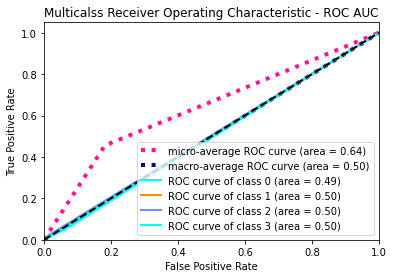

Average precision score, macro-averaged over all classes: 0.25


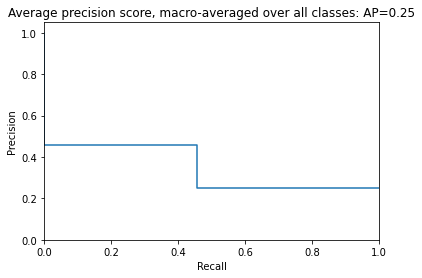

In [213]:
#Model with a reduced feature set based on tremor signatures
#Reset up train and test sets
#X prep
X_train = X_split_setup(train_df, columns_lab, target)
X_test = X_split_setup(test_df, columns_lab, target)

y = dfcur[target]
y_train, y_test = pd.DataFrame(columns=[target]),pd.DataFrame(columns=[target])
#y prep
y_train[target] = train_df[target]
y_test[target] = test_df[target]

#Prep the data - remove nas and label encode
X_train = prep_var(X_train)
X_test = prep_var(X_test)

#only include tremor features
trem_feats = ['X_bp_filt_[0.25, 3.5]_signal_entropy',
       'Y_bp_filt_[0.25, 3.5]_signal_entropy',
       'PC1_[0.25, 3.5]_signal_entropy', 'hand_movement', 'hand_amp',
       'hand_jerk', 'Peaks_EMAO','Activity_Label',
       'Entropy','Y-AutoCorrelation','FreqMaxPSD_EMAO','Entropy',
      'delta_power_p5_to_3p5_EMAO','PC1_[0.25, 3.0]_dom_freq_ratio','PC1_[0.25, 3.0]_mean_cross_rate']

X_train = X_train[trem_feats]
X_test = X_test[trem_feats]

n_PCA = int((X_train.shape[1]*0.7 // 1)) # 70% of features
X_train, X_test = PCA_X(X_train, X_test, n_PCA)

#X_train_res, y_train_res = smotetomek(X_train, y_train)
#y_train_res = pd.DataFrame(y_train_res)

clf, report = randF_simple(X_train, X_test, y_train, y_test, tuned = False)

## On_off

 1 :  29
 2 :  17
 0 :  19
 3 :  16
 4 :  1

Are any train/test measurement_ids shared? 
False
Total Explained variance: 0.8175180964677221
Training Accuracy score:  1.0

Test set results
Test Accuracy score:  0.349
Macro ROC AUC score per class : 0.529
Weighted ROC AUC score : 0.529
Macro ROC AUPrecision curve value per class : 0.266
Weighted ROC AUPrecision curve value : 0.287

 classification report: 
               precision    recall  f1-score   support

         0.0       0.23      0.19      0.21      5254
         1.0       0.40      0.64      0.50      7508
         2.0       0.25      0.11      0.16      3819
         3.0       0.35      0.23      0.27      3841
         4.0       0.00      0.00      0.00         0

    accuracy                           0.35     20422
   macro avg       0.25      0.23      0.23     20422
weighted avg       0.32      0.35      0.32     20422



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


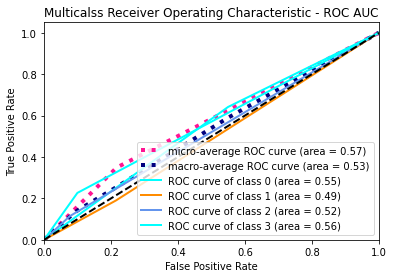

Average precision score, macro-averaged over all classes: 0.27


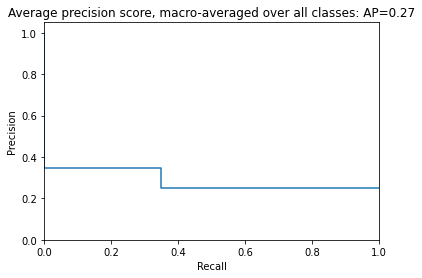

In [214]:
dfcur = df_on_off # Set the DF to tremor
target = 'on_off'
#cols = set(dfcur.columns) - set(columns_lab)
y = dfcur[target]
y_train, y_test = pd.DataFrame(columns=[target]),pd.DataFrame(columns=[target])

measurement_id = dfcur['measurement_id']

#Removed unwanted columns from feature set
X = X_split_setup(dfcur, columns_lab, target)

unique_meas = set(measurement_id)
unique_df = pd.DataFrame(dfcur.groupby(['measurement_id']).median())

label_count = CountFrequency(unique_df[target]) 

dfcur = dfcur[dfcur.columns.drop(list(dfcur.filter(regex='Rows')))]

train_meas, test_meas = get_meas_list(dfcur, unique_meas, split_ratio = 0.8)

train_df = dfcur[dfcur['measurement_id'].isin(train_meas)]
test_df = dfcur[dfcur['measurement_id'].isin(test_meas)]

print('\nAre any train/test measurement_ids shared? \n' + str(bool(set(train_df['measurement_id'])&set(test_df['measurement_id']))))

#X prep
X_train = X_split_setup(train_df, columns_lab, target)
X_test = X_split_setup(test_df, columns_lab, target)

#y prep
y_train[target] = train_df[target]
y_test[target] = test_df[target]

#Prep the data - remove nas and label encode
X_train = prep_var(X_train)
X_test = prep_var(X_test)
X_train, X_test = PCA_X(X_train, X_test)
clf, report = randF_simple(X_train, X_test, y_train, y_test, tuned = False)

#### Resampled

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=F

training score:  0.9999875024995001
score:  0.30011834319526626
Macro ROC AUC score per class : 0.5200451539971311
Weighted ROC AUC score : 0.5197276549603086
Macro Precision value per class : 0.25917159517598376
Weighted precision value : 0.268600068232893
classification report: 
               precision    recall  f1-score   support

         0.0       0.23      0.13      0.17      5691
         1.0       0.34      0.58      0.43      6580
         2.0       0.31      0.17      0.22      5078
         3.0       0.23      0.24      0.23      3776
         4.0       0.00      0.00      0.00         0

    accuracy                           0.30     21125
   macro avg       0.22      0.22      0.21     21125
weighted avg       0.28      0.30      0.27     21125



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


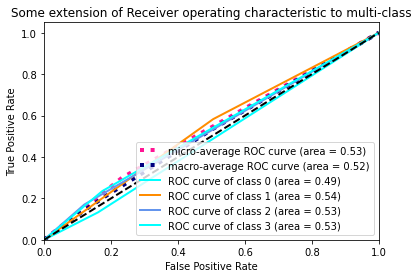

Average precision score, macro-averaged over all classes: 0.26


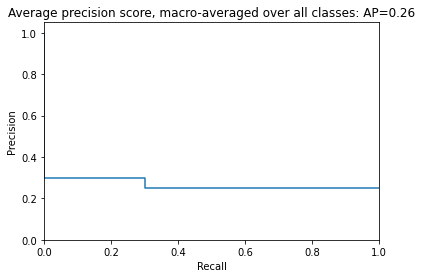

In [0]:
X_train_res, y_train_res = smotetomek(X_train, y_train)
y_train_res = pd.DataFrame(y_train_res)
clf, report = randF_simple(X_train, X_test, y_train, y_test, tuned = False)

##Dyskinesia

 1 :  26
 2 :  19
 0 :  20
 3 :  16
 4 :  1

Are any train/test measurement_ids shared? 
False
Total Explained variance: 0.8174994245519116
Training Accuracy score:  1.0

Test set results
Test Accuracy score:  0.319
Macro ROC AUC score per class : 0.534
Weighted ROC AUC score : 0.532
Macro ROC AUPrecision curve value per class : 0.268
Weighted ROC AUPrecision curve value : 0.274

 classification report: 
               precision    recall  f1-score   support

         0.0       0.25      0.23      0.24      5254
         1.0       0.35      0.54      0.43      6298
         2.0       0.32      0.20      0.25      5055
         3.0       0.34      0.23      0.27      3841
         4.0       0.00      0.00      0.00         0

    accuracy                           0.32     20448
   macro avg       0.25      0.24      0.24     20448
weighted avg       0.31      0.32      0.30     20448



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


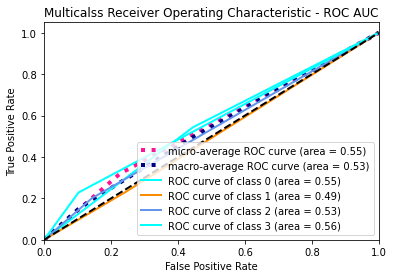

Average precision score, macro-averaged over all classes: 0.27


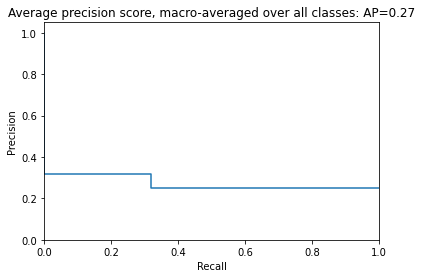

In [217]:
dfcur = df_dys # Set the DF to tremor
target = 'dyskinesia'
#cols = set(dfcur.columns) - set(columns_lab)
y = dfcur[target]
measurement_id = dfcur['measurement_id']

#Removed unwanted columns from feature set
X = X_split_setup(dfcur, columns_lab, target)

unique_meas = set(measurement_id)
unique_df = pd.DataFrame(dfcur.groupby(['measurement_id']).median())
y_train, y_test = pd.DataFrame(columns=[target]),pd.DataFrame(columns=[target])

label_count = CountFrequency(unique_df[target]) 

dfcur = dfcur[dfcur.columns.drop(list(dfcur.filter(regex='Rows')))]

train_meas, test_meas = get_meas_list(dfcur, unique_meas, split_ratio = 0.8)

train_df = dfcur[dfcur['measurement_id'].isin(train_meas)]
test_df = dfcur[dfcur['measurement_id'].isin(test_meas)]

print('\nAre any train/test measurement_ids shared? \n' + str(bool(set(train_df['measurement_id'])&set(test_df['measurement_id']))))

#X prep
X_train = X_split_setup(train_df, columns_lab, target)
X_test = X_split_setup(test_df, columns_lab, target)

#y prep
y_train[target] = train_df[target]
y_test[target] = test_df[target]

#Prep the data - remove nas and label encode
X_train = prep_var(X_train)
X_test = prep_var(X_test)
#PCA
X_train, X_test = PCA_X(X_train, X_test)

#X_train_res, y_train_res = smotetomek(X_train, y_train)
#y_train_res = pd.DataFrame(y_train_res)
clf, report = randF_simple(X_train, X_test, y_train, y_test, tuned = False)

## Combine multiple users > model

In [0]:
columns_lab = ['Timestamp', 'Reading',
            'subject_id']

user = 1004
savedir = "/content/drive/My Drive/BEAT_PD/Data/CIS-PD/training_data/HAR/merged/Windowed_Features/merged/"

df_1004 = pd.read_csv(savedir + str(user) + '.csv')

df_1004 = df_1004[df_1004.columns.drop(list(df_1004.filter(regex='Unn')))]

user = 1006
df_1006 = pd.read_csv(savedir + str(user) + '.csv')

df_1006 = df_1006[df_1006.columns.drop(list(df_1006.filter(regex='Unn')))]

user = 1019
df_1019 = pd.read_csv(savedir + str(user) + '.csv')

df_1019 = df_1019[df_1019.columns.drop(list(df_1019.filter(regex='Unn')))]

user = 1020
df_1020 = pd.read_csv(savedir + str(user) + '.csv')

df_1020 = df_1020[df_1020.columns.drop(list(df_1020.filter(regex='Unn')))]

user = 1023
df_1023 = pd.read_csv(savedir + str(user) + '.csv')

df_1023 = df_1023[df_1023.columns.drop(list(df_1023.filter(regex='Unn')))]

dfList = [df_1004, df_1006, df_1019, df_1020, df_1023]  # List of your dataframes
df = pd.concat(dfList)

In [0]:
#Select Numeric features in df
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df.select_dtypes(include=numerics)
#Select Object features in df
objs = ['O']
df.select_dtypes(include=objs)

#Split dfs by target
df_on_off = df.drop(labels= ['tremor', 'dyskinesia'], axis=1)
df_trem = df.drop(labels= ['on_off', 'dyskinesia'], axis=1)
df_dys = df.drop(labels= ['on_off', 'tremor'], axis=1)
df_on_off = df_on_off[df_on_off['on_off'].notna()]
df_trem = df_trem[df_trem['tremor'].notna()]
df_dys = df_dys[df_dys['dyskinesia'].notna()]
df_on_off = df_on_off.fillna(df_on_off.median())
df_trem = df_trem.fillna(df_trem.median())
df_dys = df_dys.fillna(df_dys.median())

#### On_off

 0 :  227
 2 :  78
 1 :  82
 3 :  46
 4 :  28

Are any train/test measurement_ids shared? 
False
Total Explained variance: 0.8308439675240485


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


training score:  0.9999666626661866
score:  0.4968045565152285
Macro ROC AUC score per class : 0.5127393020938997
Weighted ROC AUC score : 0.5187145866866187
Macro Precision value per class : 0.20798927320349506
Weighted precision value : 0.3231206625250558
classification report: 
               precision    recall  f1-score   support

         0.0       0.50      0.98      0.66     54767
         1.0       0.46      0.06      0.10     19480
         2.0       0.38      0.05      0.09     19233
         3.0       0.18      0.00      0.01     11145
         4.0       0.07      0.00      0.00      7566

    accuracy                           0.50    112191
   macro avg       0.32      0.22      0.17    112191
weighted avg       0.41      0.50      0.36    112191



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


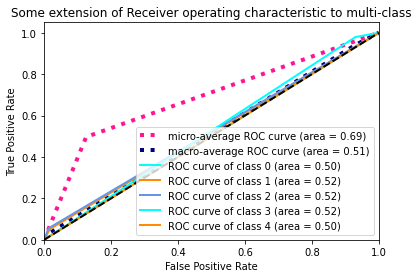

Average precision score, macro-averaged over all classes: 0.21


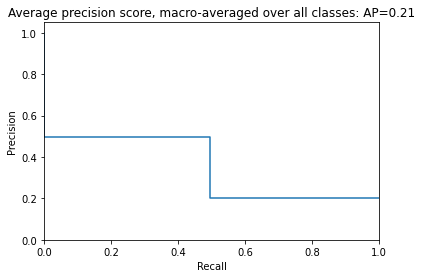

In [0]:
dfcur = df_on_off # Set the DF to tremor
target = 'on_off'
#cols = set(dfcur.columns) - set(columns_lab)
y = dfcur[target]
measurement_id = dfcur['measurement_id']

#Removed unwanted columns from feature set
X = X_split_setup(dfcur, columns_lab, target)

unique_meas = set(measurement_id)
unique_df = pd.DataFrame(dfcur.groupby(['measurement_id']).median())
y_train, y_test = pd.DataFrame(columns=[target]),pd.DataFrame(columns=[target])

label_count = CountFrequency(unique_df[target]) 

dfcur = dfcur[dfcur.columns.drop(list(dfcur.filter(regex='Rows')))]

train_meas, test_meas = get_meas_list(dfcur, unique_meas, split_ratio = 0.8)

train_df = dfcur[dfcur['measurement_id'].isin(train_meas)]
test_df = dfcur[dfcur['measurement_id'].isin(test_meas)]

print('\nAre any train/test measurement_ids shared? \n' + str(bool(set(train_df['measurement_id'])&set(test_df['measurement_id']))))

#X prep
X_train = X_split_setup(train_df, columns_lab, target)
X_test = X_split_setup(test_df, columns_lab, target)

#y prep
y_train[target] = train_df[target]
y_test[target] = test_df[target]

#Prep the data - remove nas and label encode
X_train = prep_var(X_train)
X_test = prep_var(X_test)

#PCA
X_train, X_test = PCA_X(X_train, X_test)

#Resample
#X_train_res, y_train_res = smotetomek(X_train, y_train)
#y_train_res = pd.DataFrame(y_train_res)

clf, report = randF_simple(X_train, X_test, y_train, y_test, tuned = False)